In [ ]:
!pip install -q pdf2image git+https://github.com/huggingface/transformers.git qwen-vl-utils flash-attn


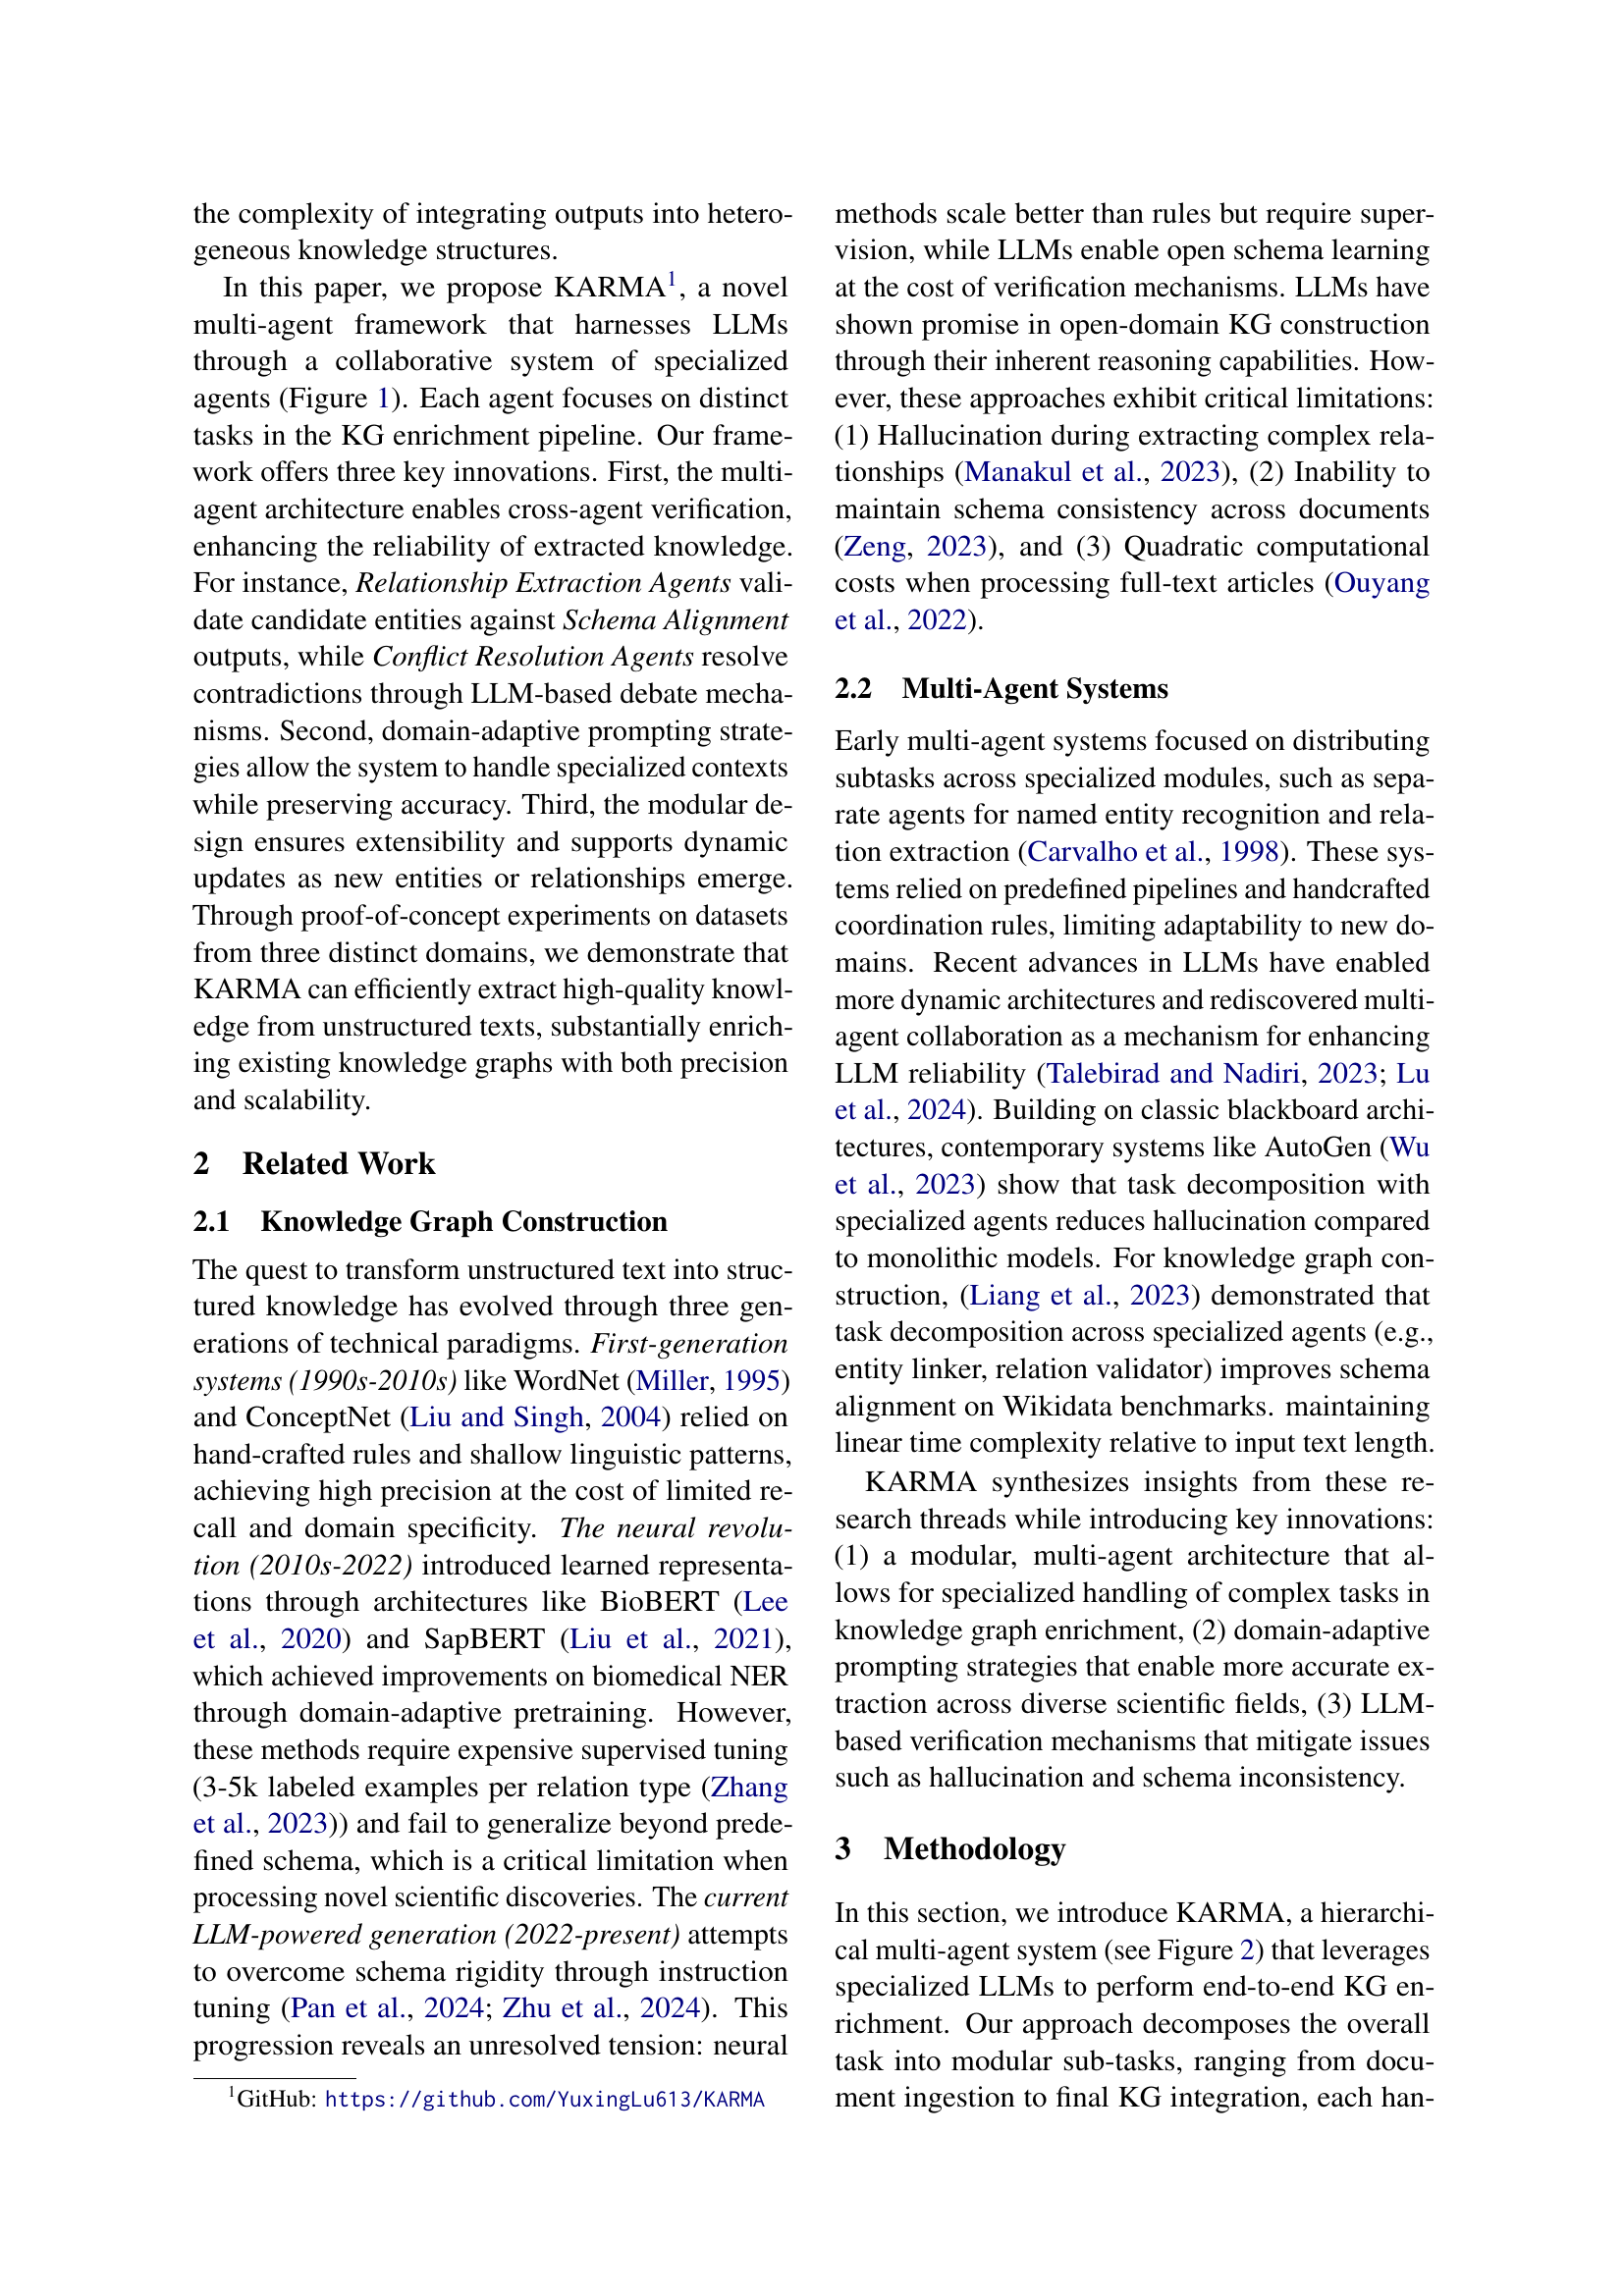

In [ ]:
from pdf2image import convert_from_path

images = convert_from_path("./data/2502.06472v1.pdf")
images[1]

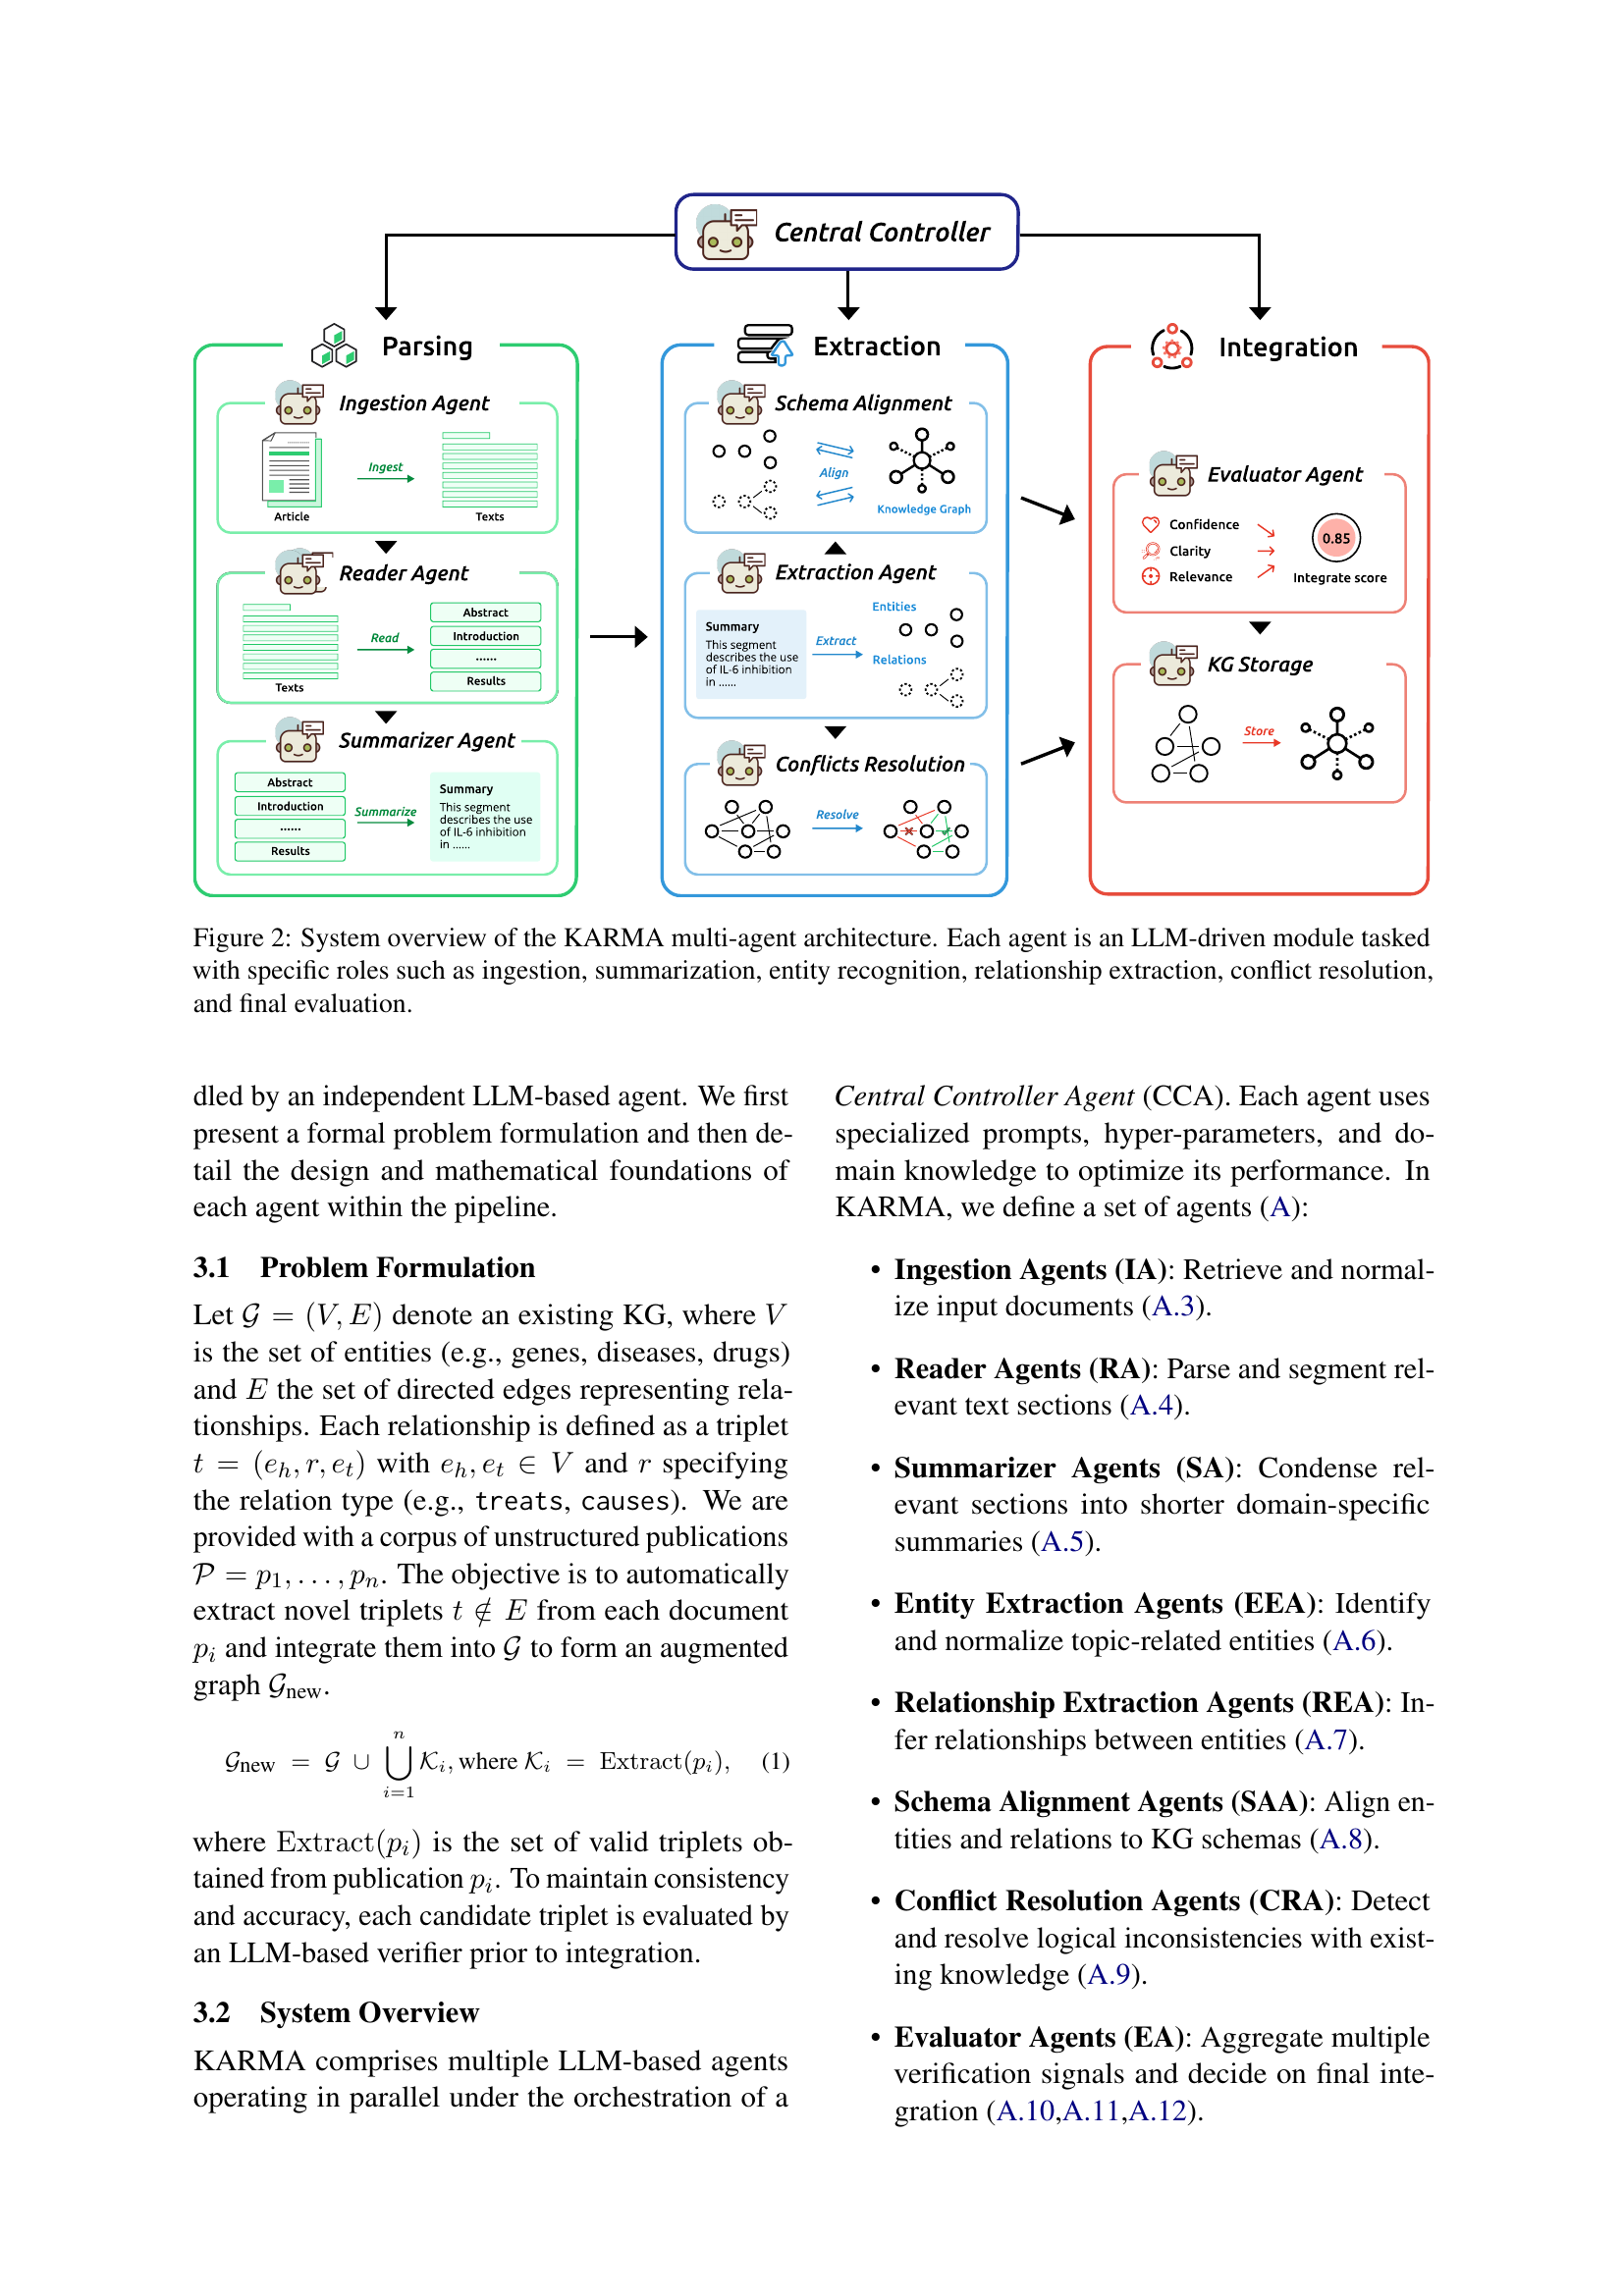

In [4]:
images[2]

In [2]:
len(images)

24

In [7]:

from byaldi import RAGMultiModalModel

RAG = RAGMultiModalModel.from_pretrained("vidore/colpali-v1.3", device="mps")

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/78.6M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/423 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/243k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.6M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

In [8]:
RAG.index(
    input_path="./data/2502.06472v1.pdf",
    index_name="agents_document_index", # index will be saved at index_root/index_name/
    store_collection_with_index=False,
    overwrite=True
)
  

Added page 1 of document 0 to index.
Added page 2 of document 0 to index.
Added page 3 of document 0 to index.
Added page 4 of document 0 to index.
Added page 5 of document 0 to index.
Added page 6 of document 0 to index.
Added page 7 of document 0 to index.
Added page 8 of document 0 to index.
Added page 9 of document 0 to index.
Added page 10 of document 0 to index.
Added page 11 of document 0 to index.


KeyboardInterrupt: 

In [1]:
text_query = "How much did the world temperature change so far?"
results = RAG.search(text_query, k=1)
results
     

NameError: name 'RAG' is not defined

In [ ]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch

model = Qwen2VLForConditionalGeneration.from_pretrained("Qwen/Qwen2-VL-2B-Instruct",
                                                        trust_remote_code=True, torch_dtype=torch.bfloat16).cuda().eval()
     


In [ ]:

processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct", trust_remote_code=True)

image_index = results[0]["page_num"] - 1
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": images[image_index],
            },
            {"type": "text", "text": text_query},
        ],
    }
]
   

In [ ]:
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
  

In [ ]:

image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

In [ ]:
generated_ids = model.generate(**inputs, max_new_tokens=50)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)


In [ ]:
print(output_text)
